# Posterior

In [1]:
%matplotlib inline

from __future__ import print_function, division

import numpy as np
import math

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import rcParams, rc
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib import gridspec, ticker

from xpsi.tools.phase_interpolator import interpolate_pulse

import sys
import xpsi
                   
import os

from xpsi import PostProcessing
PostProcessing.NSBackend.use_nestcheck = True
from xpsi.global_imports import _dpr, _keV, _k_B

from xpsi.cellmesh.mesh_tools import eval_cedeCentreCoords

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|              Version: 0.1                 |
\=============================================/

Imported GetDist version: 0.3.1
Imported nestcheck version: 0.2.0


In [2]:
PostProcessing.publication_rc_settings()

In [3]:
from xpsi.global_imports import _c, _G, _M_s, _dpr, gravradius

In [4]:
class model():
    """ A namespace if mutiple models in one notebook. """

In [5]:
from SynthesiseData import CustomData
from CustomInstrument import CustomInstrument
from CustomBackground import CustomBackground
from CustomPulse import CustomPulse
from CustomSpacetime import CustomSpacetime
from CustomPrior import CustomPrior

phase_edges = np.linspace(0.0, 1.0, 33)

data = CustomData(0, 181, phase_edges)                                                                                                    

m1 = model()

m1.NICER = CustomInstrument.from_SWG(num_params=0,                                                                                                 
                    bounds=[],                                                                                     
                    ARF = 'model_data/nicer_v1.01_arf.txt',                                                                          
                    RMF = 'model_data/nicer_v1.01_rmf_matrix.txt',                                                                                
                    max_input=500,                                                                                                              
                    min_input=0,                                                                                                                
                    chan_edges = 'model_data/nicer_v1.01_rmf_energymap.txt')                                                                      
                                                                                                                                                
background = CustomBackground(num_params = 1, bounds = [(-3.0,-1.01)])                                                                          
                                                                                                                                                
pulse = CustomPulse(tag = 'all',                                                                                                                
                    num_params = 2,                                                                                                             
                    bounds = [(-0.25, 0.75), (-0.25, 0.75)],                                                                                    
                    data = data,                                                                                                                
                    instrument = m1.NICER,                                                                                                        
                    background = background,                                                                                                    
                    interstellar = None,                                                                                                        
                    energies_per_interval = 0.5,                                                                                               
                    default_energy_spacing = 'logspace',                                                                                        
                    fast_rel_energies_per_interval = 0.5,                                                                                       
                    workspace_intervals = 1000,                                                                                                 
                    adaptive_energies=False,                                                                                                    
                    store=True,                                                                                                                 
                    epsrel = 1.0e-8,                                                                                                            
                    epsilon = 1.0e-3,                                                                                                           
                    sigmas = 10.0)                                                                                                              
                                                                                                                                             
bounds = [(0.1, 1.0),                                                                                                                           
          (1.0, 3.0),                                                                                                                           
          (3.0 * gravradius(1.0), 16.0),                                                                                                        
          (0.001, math.pi/2.0)]                                                                                                                 
                                                                                                                                                
spacetime = CustomSpacetime(num_params = 4, bounds = bounds, S = 300.0)                                                                         
                                                                                                                                                
bounds = [(0.001, math.pi - 0.001),                                                                                                             
          (0.001, math.pi/2.0 - 0.001),                                                                                                         
          (5.5, 6.5),                                                                                                                           
          (0.001, math.pi - 0.001),                                                                                                             
          (0.001, math.pi/2.0 - 0.001),                                                                                                         
          (5.5, 6.5)]                                                                                                                           
                                                                                                                                                
spot = xpsi.Spots(num_params=(3,3), bounds=bounds,                                                                                              
                    symmetry=True,                                                                                                              
                    hole=False,                                                                                                                 
                    cede=False,                                                                                                                 
                    concentric=False,                                                                                                           
                    antipodal_symmetry=False,                                                                                                   
                    sqrt_num_cells=32,                                                                                                          
                    min_sqrt_num_cells=10,                                                                                                      
                    max_sqrt_num_cells=64,                                                                                                      
                    do_fast=False,                                                                                                              
                    num_leaves=100,                                                                                                             
                    num_rays=200)                                                                                                               
                                                                                                                                                
photosphere = xpsi.Photosphere(num_params = 0, bounds = [],                                                                                     
                               tag = 'all', spot = spot, elsewhere = None)                                                                      
                                                                                                                                                
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)                                                                             
                                                                                                                                                
likelihood = xpsi.Likelihood(star = star, pulses = pulse, threads=1)                                                                            
                                                                                                                                                
prior = CustomPrior(bounds=likelihood.bounds, spacetime=spacetime)                                                                              
                                                                                                                                                
likelihood.prior = prior

No data... can synthesise data but cannot evaluate a likelihood function.


/home/thomas/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


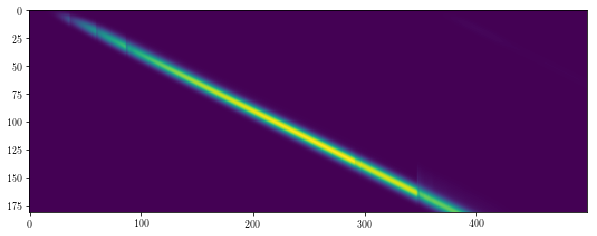

In [6]:
fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)

profile = ax.imshow(m1.NICER.matrix,
                         cmap = plt.cm.viridis,
                         rasterized = True)

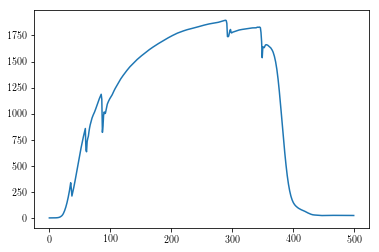

In [7]:
plt.plot(np.sum(m1.NICER.matrix, axis=0))

In [8]:
print(likelihood)

Printing the model objects in order...

Object [tag]: number of parameters
--------------------------------------
Spacetime: 4
Photosphere ['all']: 6
   --> Spot ['all']: 6
Pulse ['all']: 3
--------------------------------------
Total number of model parameters: 13


In [109]:
%env GSL_RNG_SEED=0

env: GSL_RNG_SEED=0


In [110]:
q = [0.2, 1.4, 12.5, 1.25,
     1.0, 0.075, 6.2,
     math.pi - 1.0, 0.2, 6.0,
     -2.0, 0.0, 0.025]

In [119]:
# v2
likelihood._theta = [0]*len(likelihood._theta)
likelihood.synthesise(q, require_source_counts=2.0e6, require_background_counts=2.0e6, directory='./data') #  [s] SEED=0

Exposure time: 984307.666100 [s]
Background normalisation: 1.89127972e-05


In [120]:
expec = np.loadtxt('data/synthetic_expected_hreadable.dat')

In [121]:
np.sum(expec[:,2])

3999999.9999584

In [122]:
realisation = np.loadtxt('data/synthetic_realisation.dat', dtype=np.double)

In [123]:
realisation.shape

(181, 32)

In [124]:
np.sum(realisation)

3999814.0

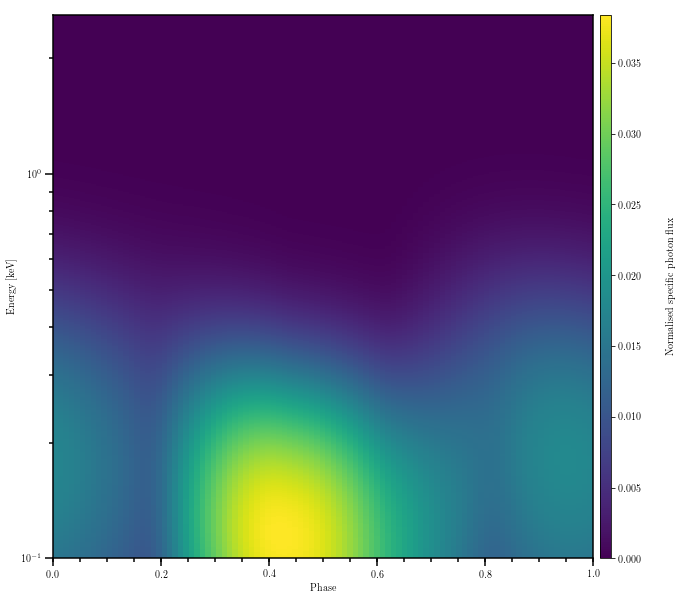

In [19]:
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec
from matplotlib import cm

fig = plt.figure(figsize = (10,10))

gs = gridspec.GridSpec(1, 2, width_ratios=[50,1])
ax = plt.subplot(gs[0])
ax_cb = plt.subplot(gs[1])

profile = ax.pcolormesh(pulse.phases,
                         pulse.logspace_energies_hires,
                         pulse.raw_signals[0] + interpolate_pulse(pulse.phases, pulse.phases, pulse.raw_signals[1], q[-1]),
                         cmap = plt.cm.viridis,
                         linewidth = 0,
                         rasterized = True)

profile.set_edgecolor('face')

ax.tick_params(which='major', colors='black', length=8)
ax.tick_params(which='minor', colors='black', length=4)
ax.xaxis.set_tick_params(which='both', width=1.5)
ax.yaxis.set_tick_params(which='both', width=1.5)
plt.setp(ax.spines.values(), linewidth=1.5, color='black')

ax.set_xlim([0.0, 1.0])
ax.set_yscale('log')
ax.set_ylim([pulse.logspace_energies_hires[0], pulse.logspace_energies_hires[-1]])
ax.set_ylabel(r'Energy [keV]')
[i.set_color("black") for i in ax.get_xticklabels()]
[i.set_color("black") for i in ax.get_yticklabels()]
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))

ax.set_xlabel(r'Phase')

cb = plt.colorbar(profile,
                  cax = ax_cb)

cb.set_label(label=r'Normalised specific photon flux', labelpad=25)
cb.solids.set_edgecolor('face')

plt.subplots_adjust(wspace = 0.025)

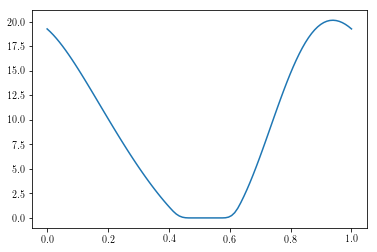

In [20]:
plt.plot(pulse.phases, np.sum(pulse.raw_signals[0], axis=0))

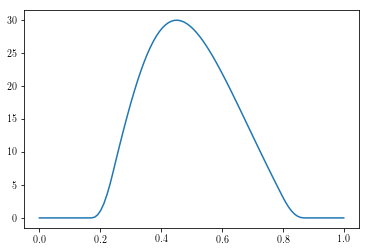

In [21]:
plt.plot(pulse.phases, np.sum(pulse.raw_signals[1], axis=0))

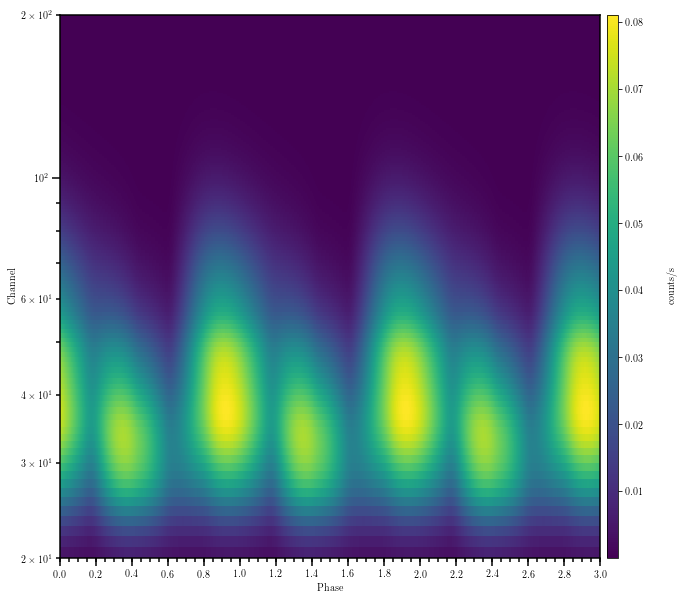

In [24]:
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec
from matplotlib import cm

fig = plt.figure(figsize = (10,10))

gs = gridspec.GridSpec(1, 2, width_ratios=[50,1])
ax = plt.subplot(gs[0])
ax_cb = plt.subplot(gs[1])

new_phases = np.linspace(0.0, 3.0, 3000)

interpolated = interpolate_pulse(new_phases, pulse.phases, pulse.pulse[0], q[-2])
interpolated += interpolate_pulse(new_phases, pulse.phases, pulse.pulse[1], q[-1])

profile = ax.pcolormesh(new_phases,
                         m1.NICER.channels,
                         interpolated,
                         cmap = plt.cm.viridis,
                         linewidth = 0,
                         rasterized = True)

profile.set_edgecolor('face')

ax.tick_params(which='major', colors='black', length=8)
ax.tick_params(which='minor', colors='black', length=4)
ax.xaxis.set_tick_params(which='both', width=1.5)
ax.yaxis.set_tick_params(which='both', width=1.5)
plt.setp(ax.spines.values(), linewidth=1.5, color='black')

ax.set_xlim([0.0, 3.0])
ax.set_yscale('log')
ax.set_ylabel(r'Channel')
[i.set_color("black") for i in ax.get_xticklabels()]
[i.set_color("black") for i in ax.get_yticklabels()]
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))

ax.set_xlabel(r'Phase')

cb = plt.colorbar(profile,
                  cax = ax_cb)

cb.set_label(label=r'counts/s', labelpad=25)
cb.solids.set_edgecolor('face')

plt.subplots_adjust(wspace = 0.025)

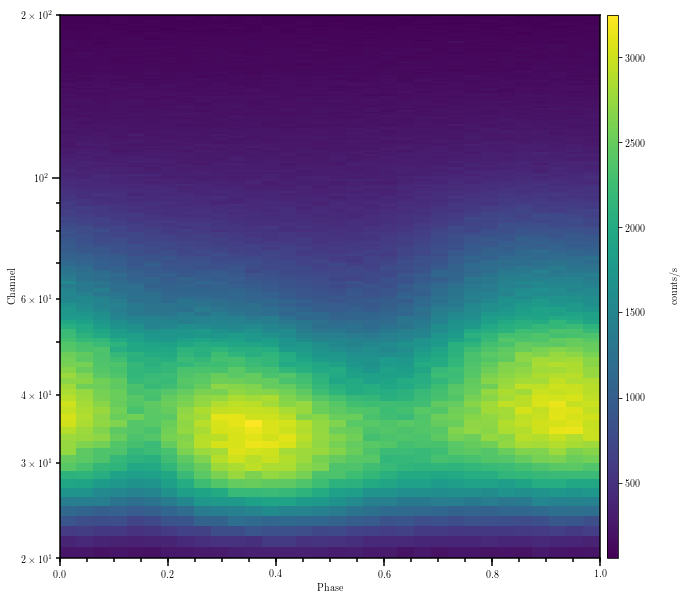

In [248]:
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec
from matplotlib import cm

fig = plt.figure(figsize = (10,10))

gs = gridspec.GridSpec(1, 2, width_ratios=[50,1])
ax = plt.subplot(gs[0])
ax_cb = plt.subplot(gs[1])

profile = ax.pcolormesh(data.phases,
                         m2.NICER.channels,
                         realisation,
                         cmap = plt.cm.viridis,
                         linewidth = 0,
                         rasterized = True)

profile.set_edgecolor('face')

ax.tick_params(which='major', colors='black', length=8)
ax.tick_params(which='minor', colors='black', length=4)
ax.xaxis.set_tick_params(which='both', width=1.5)
ax.yaxis.set_tick_params(which='both', width=1.5)
plt.setp(ax.spines.values(), linewidth=1.5, color='black')

ax.set_xlim([0.0, 1.0])
ax.set_yscale('log')
ax.set_ylabel(r'Channel')
[i.set_color("black") for i in ax.get_xticklabels()]
[i.set_color("black") for i in ax.get_yticklabels()]
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))

ax.set_xlabel(r'Phase')

cb = plt.colorbar(profile,
                  cax = ax_cb)

cb.set_label(label=r'counts/s', labelpad=25)
cb.solids.set_edgecolor('face')

plt.subplots_adjust(wspace = 0.025)

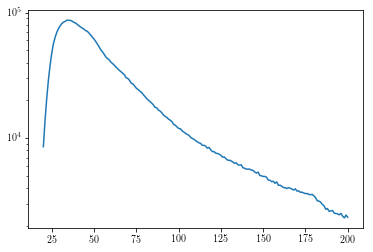

In [27]:
plt.plot(m1.NICER.channels, np.sum(realisation, axis=1))
plt.gca().set_yscale('log')

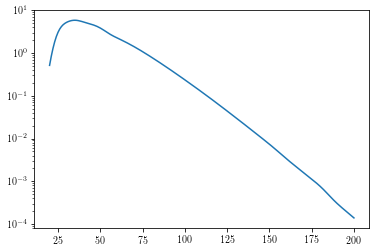

In [28]:
plt.plot(m1.NICER.channels, np.sum(pulse.pulse[0] + interpolate_pulse(pulse.phases, pulse.phases, pulse.pulse[1], q[-1]), axis=1))
plt.gca().set_yscale('log')

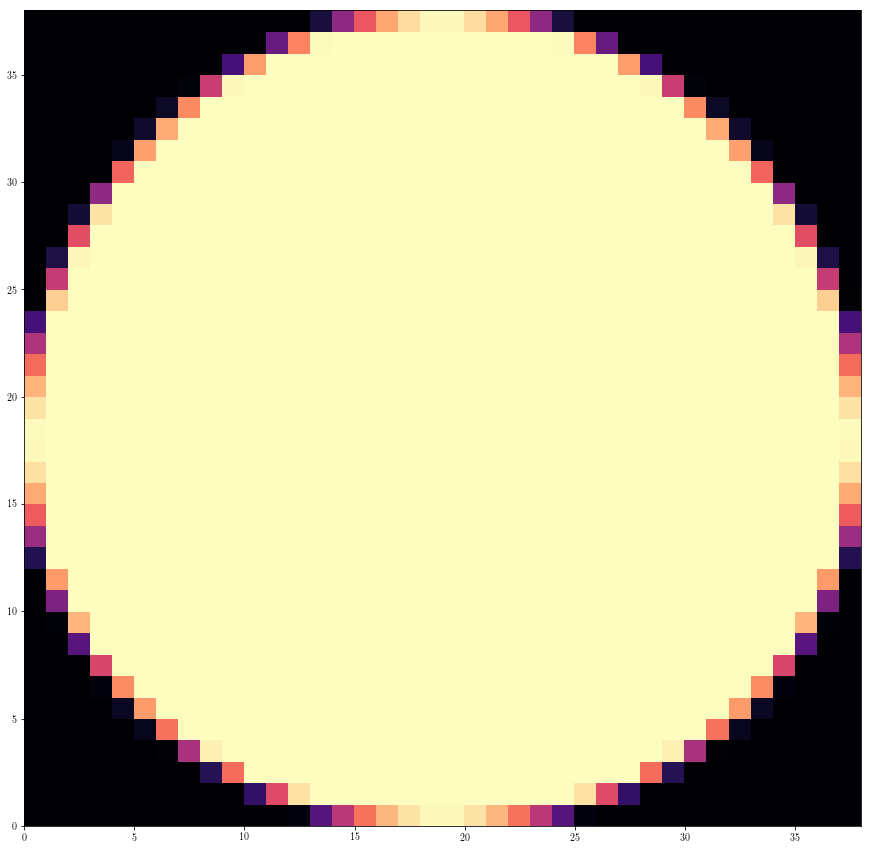

In [74]:
fig = plt.figure(figsize=(15,15))
profile = plt.pcolormesh(spot._super_cellArea,
                         cmap = plt.cm.magma,
                         linewidth = 0,
                         rasterized = True)

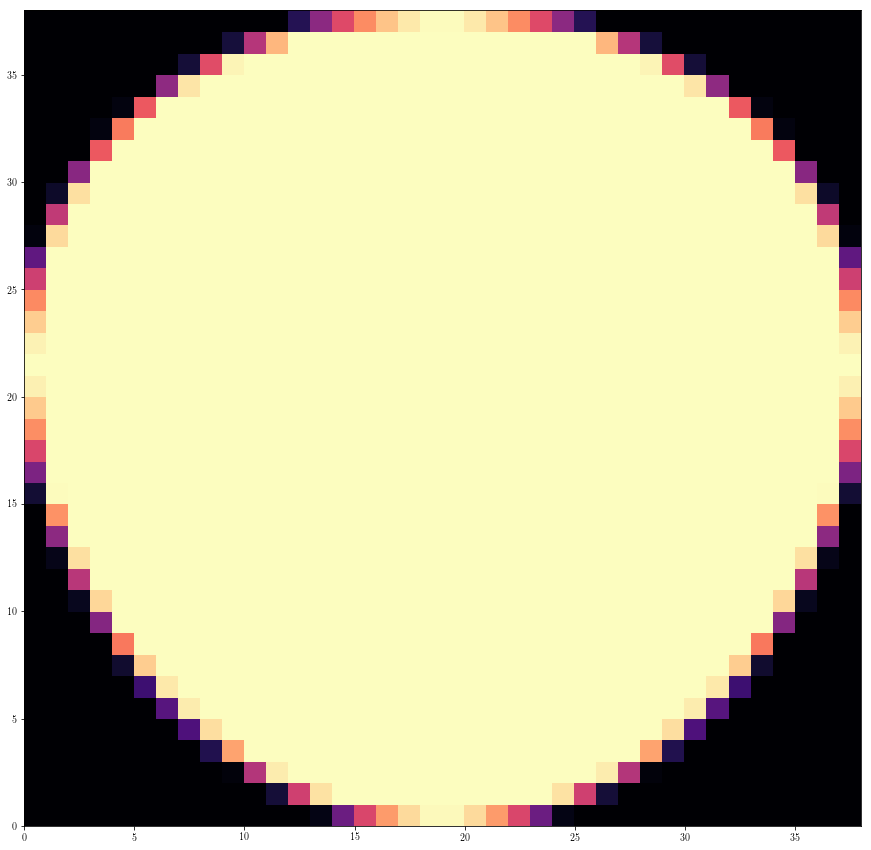

In [75]:
fig = plt.figure(figsize=(15,15))
profile = plt.pcolormesh(spot._Spots__super_cellArea,
                         cmap = plt.cm.magma,
                         linewidth = 0,
                         rasterized = True)